## Exercise 5
Suppose that you are running an advertising agency and interested in strategic result- oriented marketing by placing one of the 10 different advertisements at once to one user. The reward is 1 if the ad is clicked by the user, and 0 if not. Assume that the dataset ’Ads.csv’ provided on Moodle is the underlying rewards.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
random.seed(22)
%matplotlib inline

In [2]:
# load in the data and printing it, to get a grasp
data = pd.read_csv('Ads.csv')
print(data)

      Ad 1  Ad 2  Ad 3  Ad 4  Ad 5  Ad 6  Ad 7  Ad 8  Ad 9  Ad 10
0        1     0     0     0     1     0     0     0     1      0
1        0     0     0     0     0     0     0     0     1      0
2        0     0     0     0     0     0     0     0     0      0
3        0     1     0     0     0     0     0     1     0      0
4        0     0     0     0     0     0     0     0     0      0
...    ...   ...   ...   ...   ...   ...   ...   ...   ...    ...
9995     0     0     1     0     0     0     0     1     0      0
9996     0     0     0     0     0     0     0     0     0      0
9997     0     0     0     0     0     0     0     0     0      0
9998     1     0     0     0     0     0     0     1     0      0
9999     0     1     0     0     0     0     0     0     0      0

[10000 rows x 10 columns]


### 1. Visualize the rewards distribution, i.e. the number of being clicked by a user across all the advertisements. What do you observe?

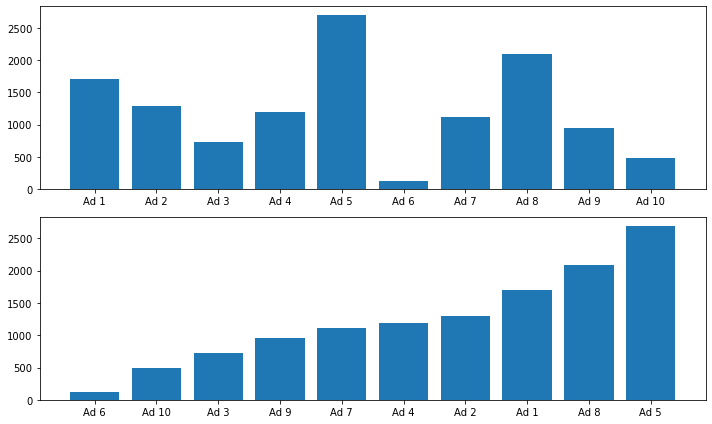

In [3]:
fig, ax = plt.subplots(2,1, figsize = (10,6))
ax[0].bar(data.sum(axis = 0).index, data.sum(axis = 0))
ax[1].bar(data.sum(axis = 0).sort_values().index, data.sum(axis = 0).sort_values())
fig.tight_layout()


Looking at the total conversions of the Ads, I realise that some Ads are rarely beeing clicked on (i.e. Ad 6 & Ad 10), while some other Ads have a relatively high conversion (i.e. Ad 5 and Ad 8).

Furthermore I noticed that every Ad can be modelled with the Binomial Distribution, as it is a sum of Bernoulli Experiments.

Considering the sorted final conversions (bottom plot), the 10 different Ads seem to be normal or even t-distributed (due to rather large tails). One problem with that, is that values below 0 would have to be excluded. 

### 2. Implement Thompson sampling algorithm to maximize the cumulative rewards. Compute the total rewards you could achieve.

In [4]:

# initialising the parameters for the beta distributions: (starting with a = b = 1, for all 10 Ads)
ad_parameters = {ad:{'a':1, 'b':1} for ad in data.columns.tolist()}
# this will be the number of wins, which starts at 0
wins = 0
for index, row in data.iterrows():
    expected_values = {}
    # initialization: first time choose randomly
    if index == 0:
        chosen_ad = random.choice(list(ad_parameters.keys()))
    # calculate the expected value of each of the 10 beta distribution/ads
    else:
        for ad in data.columns.tolist():
            # Expected value of beta distribution: a/(a+b) or (number of wins/number of games)
            expected_values[ad] = ad_parameters[ad]['a'] / (ad_parameters[ad]['a'] + ad_parameters[ad]['b'])
        # take the ad, that has the highest expected value across all ads
        chosen_ad = max(expected_values, key=lambda key: expected_values[key])

    # book as win, if the chosen ad is klicked
    if row[chosen_ad] == 1:
        wins += 1

    # update the parameters (when its a win, increment 'a', when its a loss increment 'b')
    for ads in data.columns.tolist():
        if row[ads] == 1:
            ad_parameters[ads]['a'] += 1
        else:
            ad_parameters[ads]['b'] += 1


print(f'Out of the 10000 possibile ad conversions, we had {wins} successful ones')  


Out of the 10000 possibile ad conversions, we had 2690 successful ones


In [5]:
print(data.sum().sort_values())

Ad 6      126
Ad 10     489
Ad 3      728
Ad 9      952
Ad 7     1112
Ad 4     1196
Ad 2     1295
Ad 1     1703
Ad 8     2091
Ad 5     2695
dtype: int64


Using Thompson sampling, we seem to have a very good strategy, as we have 2690 successful conversions. When we look at the conversion rate of each Ad, we see that the highest converting ad (Ad 5) had 2695, so only 5 more conversions than we did.

And all this, while not knowing from the beginning which Ad would perform the best.

### 3. Implement a function that computes the expected regret using the formula discussed in Lecture 4. Compute the regret.

The optimal ad is Ad 5, as it yields the highest returns, $a* = $ Ad 5 

Computing the function that calculates the regret(T) will use the base code of the Thomson Sampling above.

In [6]:

def regret(T = 10000, use_thomson_sampling = True):
    random.seed(22)
    # defining the optimal Ad
    opt_ad = 'Ad 5'
    regrets = []
    # initialising the parameters for the beta distributions: (starting with a = b = 1, for all 10 Ads)
    ad_parameters = {ad:{'a':1, 'b':1} for ad in data.columns.tolist()}

    # iterating through the dataset: (only T rows, if T is defined)
    for index, row in data[:T].iterrows():
        expected_values = {}
        # choosing the ad, either random, or based on thomson sampling
        if use_thomson_sampling:
            if index == 0:
                chosen_ad = random.choice(list(ad_parameters.keys()))
            # calculate the expected value of each of the 10 beta distribution
            else:
                for ad in data.columns.tolist():
                    expected_values[ad] = ad_parameters[ad]['a'] / (ad_parameters[ad]['a'] + ad_parameters[ad]['b'])
                # take the ad, that has the highest expected value across all ads
                chosen_ad = max(expected_values, key=lambda key: expected_values[key])
            # update the parameters (when its a win, increment 'a', when its a loss increment 'b')
            for ads in data.columns.tolist():
                if row[ads] == 1:
                    ad_parameters[ads]['a'] += 1
                else:
                    ad_parameters[ads]['b'] += 1
        else:
            chosen_ad = random.choice(list(ad_parameters.keys()))

        # calculate the regret of this step (give good intuition of regret)
        if (row[chosen_ad] == 1) & (row[opt_ad] == 1):
            regrets.append(0)
        elif(row[chosen_ad] == 1) & (row[opt_ad] == 0):
            regrets.append(-1)
        elif(row[chosen_ad] == 0) & (row[opt_ad] == 1):
            regrets.append(1)
        else:
            regrets.append(0)
        
        # The following does the same: (formula mathes the mathematical expression more)
        # regrets.append(row[opt_ad] - row[chosen_ad])

    # return the cumulative sum over the regrets
    return np.cumsum(regrets)

This function takes the 'Time' T as parameter as well as a boolean parameter, indicating whether to use Thomson sampling or not.

It returns the cumulative timseries of the regrets, i.e. $\{Regret(t)|t \in \{1,\ldots, T\}\}$

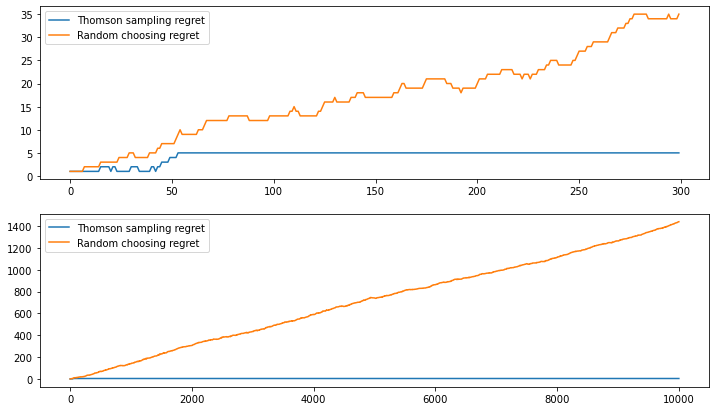

In [7]:
fig, ax = plt.subplots(2,1,figsize = (12,7))
ax[0].plot(regret(T = 300, use_thomson_sampling = True), label = 'Thomson sampling regret')
ax[0].plot(regret(T = 300, use_thomson_sampling = False), label = 'Random choosing regret')
ax[0].legend()

ax[1].plot(regret(T = 10000, use_thomson_sampling = True), label = 'Thomson sampling regret')
ax[1].plot(regret(T = 10000, use_thomson_sampling = False), label = 'Random choosing regret')
ax[1].legend()
plt.show()

In this plot we can see, that the regret of Thomson Sampling after ~50 steps is constant at 5. This means, that after about 50 steps, this method identified the optimal Advertisement.

When choosing the Ads randomly every time, the regret grows linearly.
